In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# 统计标签集
# filename = 'data/train_TAG.txt'

# # 初始化一个集合来存储所有唯一的标签
# tag_set = set()

# # 打开文件并逐行读取
# with open(filename, 'r', encoding='utf-8') as file:
#     for line in file:
#         # 分割每一行中的标签 再通过空格分隔
#         tags = line.strip().split()
#         # 更新集合，自动去除重复的标签
#         tag_set.update(tags)

# # 将集合转换为列表
# tag_list = list(tag_set)

# # 打印标签集，或者可以根据需要进行其他操作
# print(tag_list)
# ['I_LOC', 'B_T', 'B_ORG', 'B_PER', 'I_T', 'I_PER', 'I_ORG', 'B_LOC', 'O']

# 将标签集保存到文件
# with open('tag_set.txt', 'w', encoding='utf-8') as f:
#     for tag in tag_list:
#         f.write(tag + '\n')

In [2]:
tag_set = []
# 打开文件并逐行读取
with open('tag_set.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # 分割每一行中的标签 再通过空格分隔
        tags = line.strip().split()
        # 更新集合，自动去除重复的标签
        tag_set += tags
tag_set += ['pad']

In [3]:
tag_set

['I_LOC',
 'B_T',
 'B_ORG',
 'B_PER',
 'I_T',
 'I_PER',
 'I_ORG',
 'B_LOC',
 'O',
 'pad']

In [4]:
num_labels = len(tag_set)

In [5]:
# 创建标签到索引的映射
label2idx = {label: idx for idx, label in enumerate(tag_set)}

In [6]:
# 数据准备
class NERDataset(Dataset):
    def __init__(self, texts, tags, tokenizer, max_len, label2idx):
        self.texts = texts
        self.tags = tags
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label2idx = label2idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tags = self.tags[idx]

        label_ids = [self.label2idx[label] for label in tags]

        # 编码文本和标签
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        # 创建标签的mask，因为只对真实单词计算loss
        labels = [self.label2idx['pad']] * self.max_len
        actual_length = min(len(label_ids), self.max_len)
        labels[:actual_length] = label_ids[:actual_length]

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.long)
        }


In [ ]:
# encoding['attention_mask'].flatten()
# tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
#          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#          0, 0, 0, 0, 0, 0, 0, 0]])

# input_ids
# tensor([ 101,  782, 3696, 5381,  122, 3299,  122, 3189, 6380, 2945,  517, 5294,
#         5276, 3198, 2845,  518, 2845, 6887,  117, 5401, 1744, 1290, 2209, 6125,
#         5500, 2356, 1762, 8138, 2399, 4638, 3297, 1400,  671, 1921, 5326, 5330,
#          677, 3885,  117, 1469, 1059, 4413, 5500, 2356,  671, 3416,  117, 6963,
#          809, 3297, 7770, 5279, 2497, 2772, 2970, 6818, 3297, 7770, 5279, 2497,
#         5310, 3338, 3315, 2399, 4638,  769, 3211,  511,  102,    0,    0,    0,
#            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
#            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
#            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
#            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
#            0,    0,    0,    0,    0,    0,    0,    0])

In [7]:
train_texts = []
train_tags = []

# 读取文本文件
with open('data/train.txt', 'r', encoding='utf-8') as file_texts:
    train_texts = [line.strip().replace(' ', '') for line in file_texts if line.strip()]

# 读取标签文件
with open('data/train_TAG.txt', 'r', encoding='utf-8') as file_tags:
    train_tags = [line.strip().split() for line in file_tags if line.strip()]

# 检查提取的结果
print("示例文本：", train_texts[0])  # 显示第一个处理后的文本
print("示例标签：", train_tags[0])  # 显示第一个处理后的标签列表


示例文本： 人民网1月1日讯据《纽约时报》报道,美国华尔街股市在2013年的最后一天继续上涨,和全球股市一样,都以最高纪录或接近最高纪录结束本年的交易。
示例标签： ['O', 'O', 'O', 'B_T', 'I_T', 'I_T', 'I_T', 'O', 'O', 'O', 'B_LOC', 'I_LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'B_LOC', 'I_LOC', 'I_LOC', 'I_LOC', 'I_LOC', 'O', 'O', 'O', 'B_T', 'I_T', 'I_T', 'I_T', 'I_T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [8]:
dev_texts = []
dev_tags = []

# 读取文本文件
with open('data/dev.txt', 'r', encoding='utf-8') as file_texts:
    dev_texts = [line.strip().replace(' ', '') for line in file_texts if line.strip()]

# 读取标签文件
with open('data/dev_TAG.txt', 'r', encoding='utf-8') as file_tags:
    dev_tags = [line.strip().split() for line in file_tags if line.strip()]

In [9]:
# 切割函数，使用正则表达式按逗号和句号切割
def split_text(texts, tags, batchsize=128):
    '''
    参数:
    texts: 一个包含多个文本序列的列表 每个文本序列是一个字符串列表。
    tags: 一个包含多个标签序列的列表 每个标签序列是一个字符串列表 与texts中的文本序列一一对应。
    batchsize: 一个整数 表示批处理大小 即每个小批次中的文本和标签序列的最大长度。默认值为128。

    返回:
    split_texts: 一个包含多个文本序列的列表 每个文本序列是一个字符串列表。这些文本序列是根据批处理大小从输入的文本序列中分割出来的。
    split_tags: 一个包含多个标签序列的列表 每个标签序列是一个字符串列表 与split_texts中的文本序列一一对应。这些标签序列是根据批处理大小从输入的标签序列中分割出来的。
    '''
    split_texts = []
    split_tags = []
    for (text, tag) in zip(texts, tags):
        if len(text) > batchsize:
            num = int(len(text) / batchsize)
            for i in range(num):
                split_texts.append(text[batchsize * i: batchsize * (i+1)])
                split_tags.append(tag[batchsize * i: batchsize * (i+1)])
        else:
            split_texts.append(text)
            split_tags.append(tag)
    return split_texts, split_tags

# 使用函数切割文本
split_train_texts , split_train_tags= split_text(train_texts, train_tags)
split_dev_texts, split_dev_tags = split_text(dev_texts, dev_tags)

In [10]:
tokenizer = BertTokenizer.from_pretrained('./bert_tokenizer')
train_dataset = NERDataset(split_train_texts, split_train_tags, tokenizer, max_len=128, label2idx=label2idx)
dev_dataset = NERDataset(split_dev_texts, split_dev_tags, tokenizer, max_len=128, label2idx=label2idx)

In [2]:
model = BertForTokenClassification.from_pretrained('./bert_model')

# 冻结所有参数
for param in model.parameters():
    param.requires_grad = True

# 解冻分类器层的参数
for param in model.classifier.parameters():
    param.requires_grad = True


In [4]:
print(model)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [12]:
def evaluate_model(model, dev_dataset, device):
    '''
    参数:
    model: 需要评估的模型。
    dev_dataset: 用于评估模型的数据集。
    device: 用于运行模型的设备，例如'cpu'或'cuda'。

    返回:
    accuracy: 模型在开发集上的准确率。

    在开发集上评估模型的性能
    '''
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)  # 验证时不需要shuffle

    model.eval()  # 设置模型为评估模式
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # 禁用梯度计算
        for batch_idx, batch in enumerate(dev_loader):
            # 将数据移动到gpu上
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 移除labels参数，因为我们不希望在评估时进行损失计算或后向传播
            outputs = model(input_ids, attention_mask=attention_mask)
            
            prob = F.softmax(outputs.logits, dim=-1)  # 得到每个位置上每个类别的概率

            # 获取最高概率的类别索引，即预测类别
            preds = torch.argmax(prob, dim=-1)  # torch.Size([32, 128])
            
            # 计算正确预测的数量
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0) * labels.size(1)

    accuracy = total_correct / total_samples
    return accuracy
    

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# 优化器
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
# 初始化梯度缩放器
scaler = GradScaler()

def train_model(model, data_loader, optimizer, device):
    '''
    参数:
    model: 需要训练的模型。
    data_loader: 用于训练模型的数据加载器。
    optimizer: 用于优化模型的优化器。
    device: 用于运行模型的设备 在这里是'cuda'。

    返回:
    total_loss / len(data_loader): 模型在训练过程中的平均损失。

    训练模型
    '''
    model.train()
    total_loss = 0
    
    # 使用tqdm来包装data_loader，显示每个batch的进度
    for batch in tqdm(data_loader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()  # 将梯度置零放在循环开始处，以避免潜在的优化问题

        # 自动管理混合精度的上下文
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        # 使用梯度缩放进行反向传播
        scaler.scale(loss).backward()
        scaler.step(optimizer)  # 使用scaler来更新模型参数
        scaler.update()  # 更新缩放器

        total_loss += loss.item()
    
    return total_loss / len(data_loader)

# 假设你已经定义了train_dataset, model, optimizer, device
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



In [14]:
train_losses = []
validation_accuracies = []
for epoch in range(10):
    loss = train_model(model, train_loader, optimizer, device)
    validation_accuracy = evaluate_model(model, dev_dataset, device)
    
    print(f"Epoch {epoch+1}, Train Loss: {loss:.4f}, Validation Accuracy: {validation_accuracy*100:.2f}%")
    
    # 收集每个epoch的数据
    train_losses.append(loss)
    validation_accuracies.append(validation_accuracy)


Epoch 1, Train Loss: 0.0466, Validation Accuracy: 99.16%


Epoch 2, Train Loss: 0.0210, Validation Accuracy: 99.32%


Epoch 3, Train Loss: 0.0161, Validation Accuracy: 99.37%


Epoch 4, Train Loss: 0.0134, Validation Accuracy: 99.41%


Epoch 5, Train Loss: 0.0118, Validation Accuracy: 99.41%


Epoch 6, Train Loss: 0.0103, Validation Accuracy: 99.47%


Epoch 7, Train Loss: 0.0095, Validation Accuracy: 99.47%


Epoch 8, Train Loss: 0.0087, Validation Accuracy: 99.48%


Epoch 9, Train Loss: 0.0080, Validation Accuracy: 99.48%


Epoch 10, Train Loss: 0.0076, Validation Accuracy: 99.46%


In [15]:
# 下载并保存模型到指定目录
save_directory1 = './trains/train1/bert_tokenizer/'
save_directory2 = './trains/train1/bert_model/'
tokenizer.save_pretrained(save_directory1)
model.save_pretrained(save_directory2)

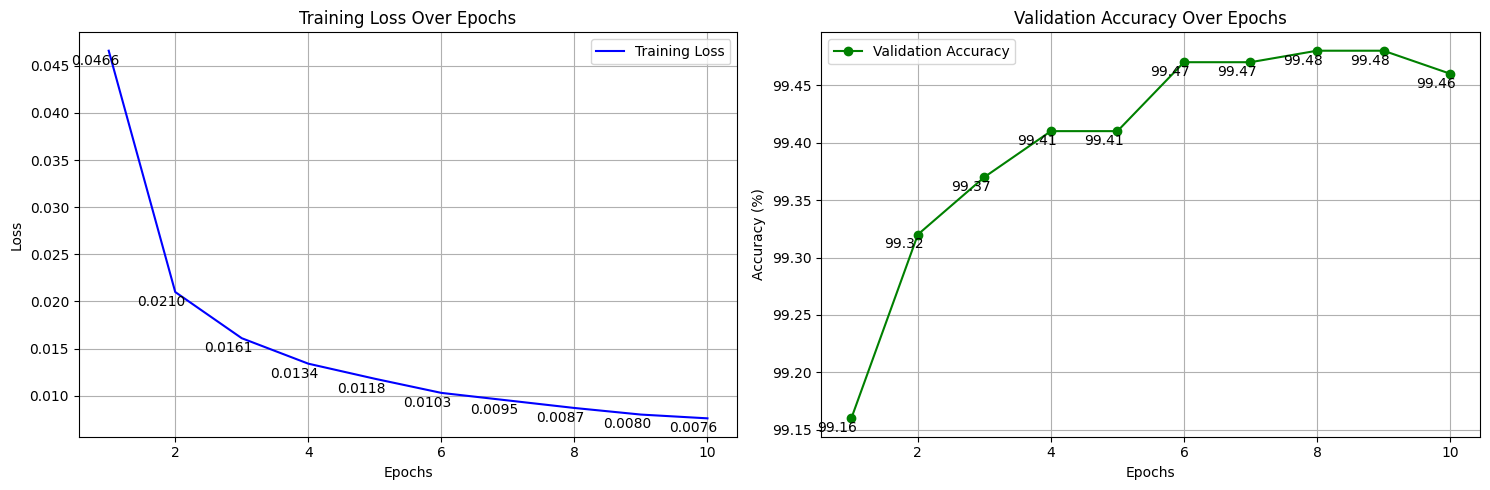

In [2]:
# 创建一个画布，包含两个子图
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# 绘制训练损失曲线
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
for i, loss in enumerate(train_losses, start=1):
    axs[0].annotate(f'{loss:.4f}', (i, loss), textcoords="offset points", xytext=(-10,-10), ha='center')

axs[0].set_title('Training Loss Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].grid(True)
axs[0].legend()

# 绘制验证准确率曲线
axs[1].plot(range(1, len(validation_accuracies) + 1), [acc for acc in validation_accuracies], 
             label='Validation Accuracy', color='green', marker='o')
for i, acc in enumerate(validation_accuracies, start=1):
    axs[1].annotate(f'{acc:.2f}', (i, acc), textcoords="offset points", xytext=(-10,-10), ha='center')

axs[1].set_title('Validation Accuracy Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid(True)
axs[1].legend()

# 调整子图间距
plt.tight_layout()

plt.show()